## Imports & Φόρτωση Δεδομένων

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from collections import Counter
from scipy.stats import mode

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


# 

In [5]:
df = sns.load_dataset('mpg')
print(f"Αρχικό shape: {df.shape}")

df = df.drop(columns=['name'])
df = df.dropna()
print(f"Μετά τον καθαρισμό: {df.shape}")

feature_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
X = df[feature_cols].values
y_raw = df['origin'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

print(f"\nFeatures shape: {X.shape}")
print(f"Κλάσεις: {label_encoder.classes_} -> {np.unique(y)}")
df.head()

Αρχικό shape: (398, 9)
Μετά τον καθαρισμό: (392, 8)

Features shape: (392, 7)
Κλάσεις: ['europe' 'japan' 'usa'] -> [0 1 2]


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,usa
1,15.0,8,350.0,165.0,3693,11.5,70,usa
2,18.0,8,318.0,150.0,3436,11.0,70,usa
3,16.0,8,304.0,150.0,3433,12.0,70,usa
4,17.0,8,302.0,140.0,3449,10.5,70,usa


## Γραφική Αναπαράσταση Δεδομένων

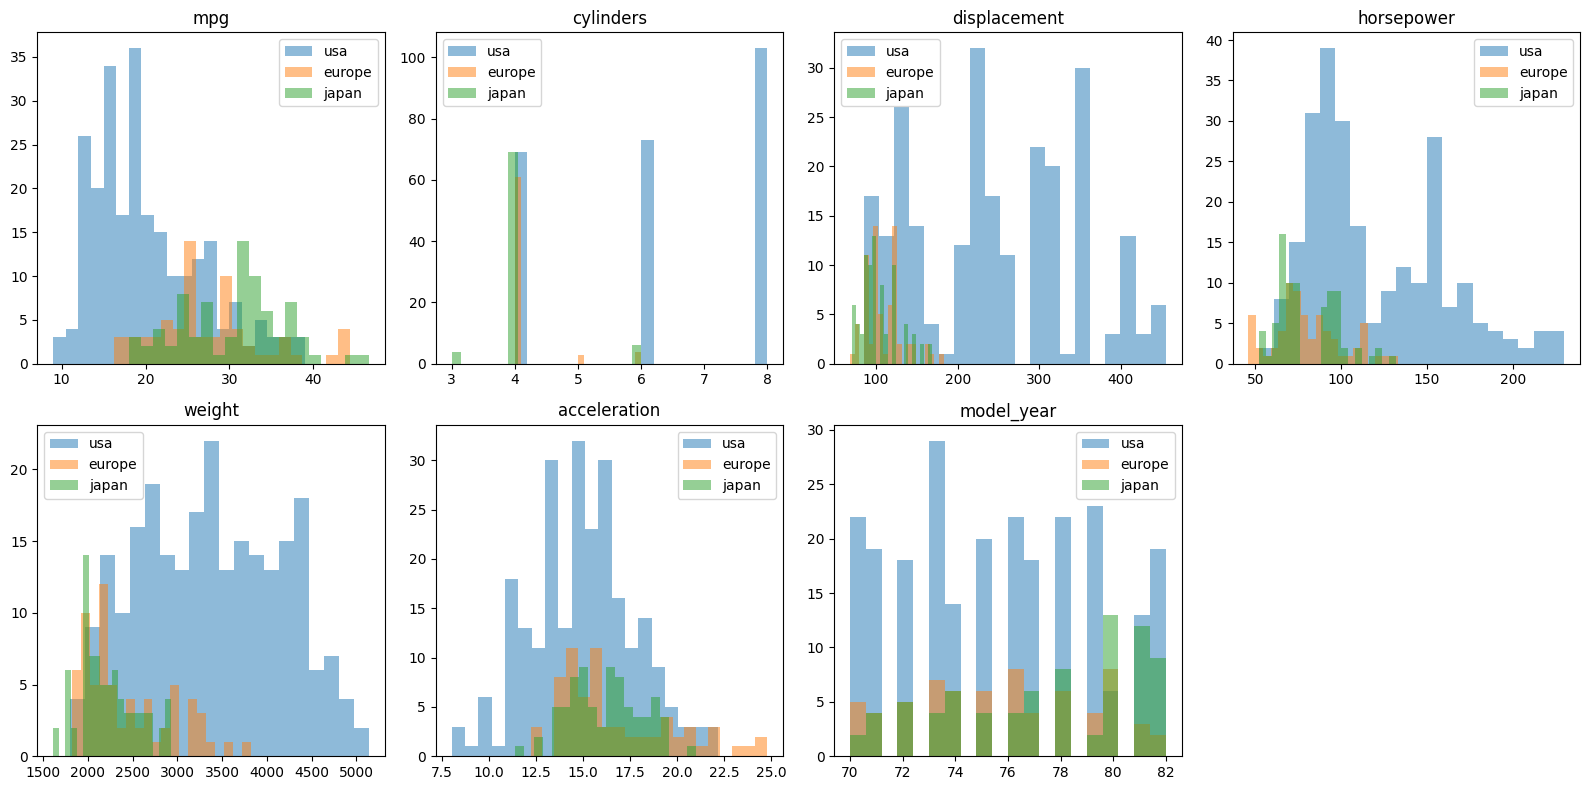

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    for origin in ['usa', 'europe', 'japan']:
        subset = df[df['origin'] == origin][col]
        axes[i].hist(subset, alpha=0.5, label=origin, bins=20)
    axes[i].set_title(col)
    axes[i].legend()

axes[-1].axis('off')
plt.tight_layout()
plt.show()

---
---
---

# 1. Principal Component Analysis (PCA)

**Στόχος:** Μείωση διαστάσεων από 7 σε 2 με PCA

---

## 1.1 Scaling Δεδομένων


In [44]:
scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X)

print(f"Scaled data shape: {X_scaled_pca.shape}")

Scaled data shape: (392, 7)


## 1.2 Manual PCA Implementation

**Βήματα:**
1. Κεντράρισμα δεδομένων (αφαίρεση μέσου)
2. Υπολογισμός πίνακα συνδιακύμανσης
3. Eigenvalue decomposition
4. Επιλογή κύριων συνιστωσών
5. Προβολή δεδομένων

In [45]:
class ManualPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.eigenvalues = None
        self.explained_variance_ratio = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        cov_matrix = np.cov(X_centered, rowvar=False)
        
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        self.eigenvalues = eigenvalues[:self.n_components]
        self.components = eigenvectors[:, :self.n_components]
        self.explained_variance_ratio = self.eigenvalues / np.sum(eigenvalues)
        
        return self
    
    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

## 1.3 Εφαρμογή Manual PCA

In [46]:
manual_pca = ManualPCA(n_components=2)
X_pca_manual = manual_pca.fit_transform(X_scaled_pca)

print(f"Αρχικές διαστάσεις: {X_scaled_pca.shape[1]}")
print(f"Μειωμένες διαστάσεις: {X_pca_manual.shape[1]}")
print(f"\nExplained Variance Ratio:")
print(f"  PC1: {manual_pca.explained_variance_ratio[0]:.4f}")
print(f"  PC2: {manual_pca.explained_variance_ratio[1]:.4f}")
print(f"  Σύνολο: {np.sum(manual_pca.explained_variance_ratio):.4f}")

Αρχικές διαστάσεις: 7
Μειωμένες διαστάσεις: 2

Explained Variance Ratio:
  PC1: 0.7158
  PC2: 0.1237
  Σύνολο: 0.8395


## 1.4 Scatter Plot - Manual PCA

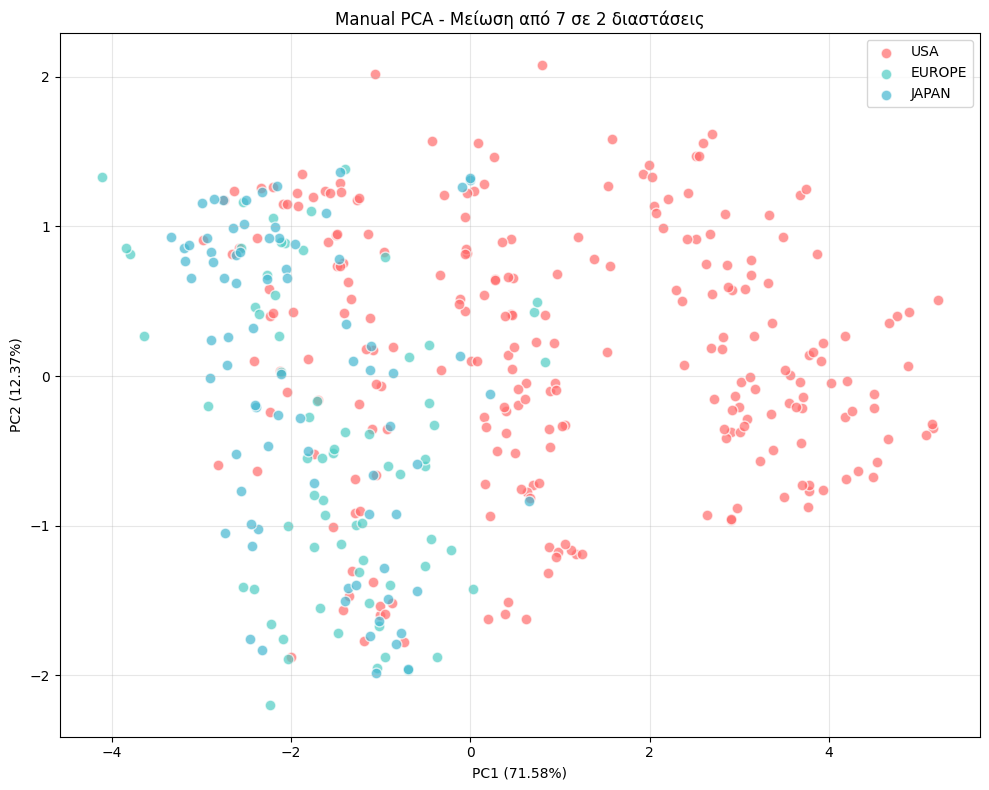

In [47]:
colors = {'usa': '#FF6B6B', 'europe': '#4ECDC4', 'japan': '#45B7D1'}

plt.figure(figsize=(10, 8))

for origin in ['usa', 'europe', 'japan']:
    mask = y_raw == origin
    plt.scatter(X_pca_manual[mask, 0], X_pca_manual[mask, 1], 
                c=colors[origin], label=origin.upper(), alpha=0.7, edgecolors='white', s=60)

plt.xlabel(f'PC1 ({manual_pca.explained_variance_ratio[0]:.2%})')
plt.ylabel(f'PC2 ({manual_pca.explained_variance_ratio[1]:.2%})')
plt.title('Manual PCA - Μείωση από 7 σε 2 διαστάσεις')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1.5 Verification με sklearn PCA

In [48]:
sklearn_pca = PCA(n_components=2)
X_pca_sklearn = sklearn_pca.fit_transform(X_scaled_pca)

print("=== Σύγκριση Manual vs sklearn PCA ===")
print(f"\nExplained Variance Ratio:")
print(f"  Manual:  PC1={manual_pca.explained_variance_ratio[0]:.6f}, PC2={manual_pca.explained_variance_ratio[1]:.6f}")
print(f"  sklearn: PC1={sklearn_pca.explained_variance_ratio_[0]:.6f}, PC2={sklearn_pca.explained_variance_ratio_[1]:.6f}")

=== Σύγκριση Manual vs sklearn PCA ===

Explained Variance Ratio:
  Manual:  PC1=0.715805, PC2=0.123656
  sklearn: PC1=0.715805, PC2=0.123656


In [49]:
X_pca_sklearn_adjusted = X_pca_sklearn.copy()
for i in range(2):
    correlation = np.corrcoef(X_pca_manual[:, i], X_pca_sklearn[:, i])[0, 1]
    if correlation < 0:
        X_pca_sklearn_adjusted[:, i] *= -1

mse = np.mean((X_pca_manual - X_pca_sklearn_adjusted) ** 2)
print(f"\nMean Squared Error μεταξύ υλοποιήσεων: {mse:.10f}")
print(f"Οι υλοποιήσεις είναι {'πρακτικά ίδιες' if mse < 1e-10 else 'παρόμοιες'}!")


Mean Squared Error μεταξύ υλοποιήσεων: 0.0000000000
Οι υλοποιήσεις είναι πρακτικά ίδιες!


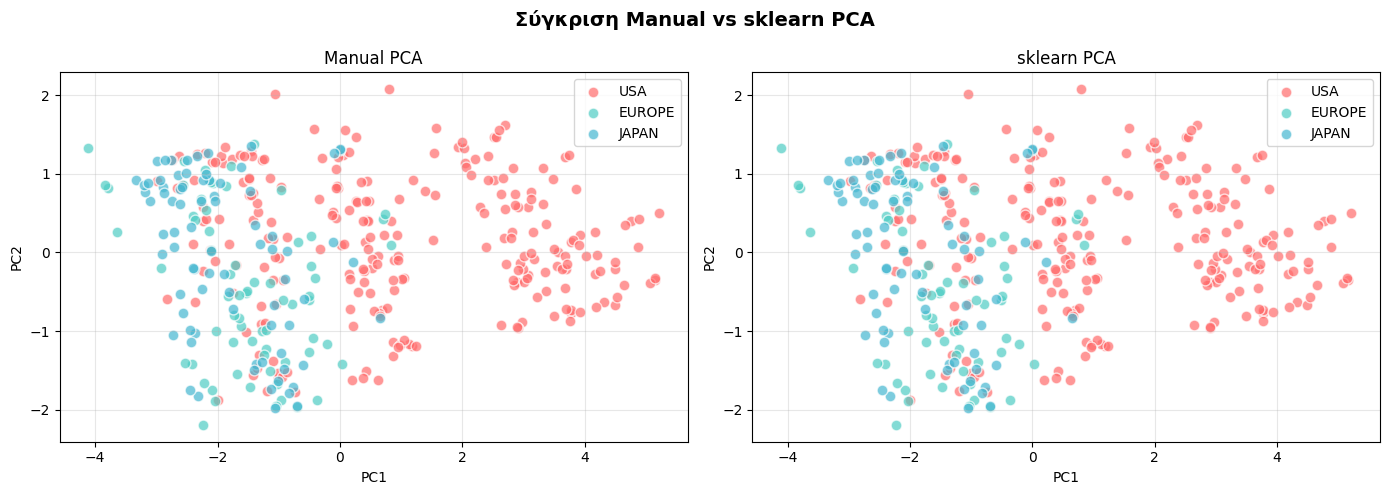

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for origin in ['usa', 'europe', 'japan']:
    mask = y_raw == origin
    axes[0].scatter(X_pca_manual[mask, 0], X_pca_manual[mask, 1], 
                    c=colors[origin], label=origin.upper(), alpha=0.7, edgecolors='white', s=60)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Manual PCA')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for origin in ['usa', 'europe', 'japan']:
    mask = y_raw == origin
    axes[1].scatter(X_pca_sklearn[mask, 0], X_pca_sklearn[mask, 1], 
                    c=colors[origin], label=origin.upper(), alpha=0.7, edgecolors='white', s=60)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('sklearn PCA')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Σύγκριση Manual vs sklearn PCA', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 1.6 Συμπεράσματα PCA

Παρατηρούμε ότι στα διαγράμματα, οι κλάσεις **δεν είναι πλήρως διαχωρίσιμες** στον χώρο των 2 κύριων συνιστωσών. Υπάρχει σημαντικό **overlap**, ειδικά μεταξύ των κλάσεων Europe και Japan.

Αυτό υποδηλώνει ότι:
1.  **Μη Γραμμικότητα:** Η δομή των δεδομένων πιθανότατα δεν είναι γραμμικά διαχωρίσιμη σε 2 διαστάσεις.
2.  **Απώλεια Πληροφορίας:** Η μείωση από 7 σε 2 διαστάσεις, αν και συγκεντρώνει σημαντικό ποσοστό της διακύμανσης, ενδέχεται να χάνει πληροφορία που είναι κρίσιμη για τον διαχωρισμό των συγκεκριμένων κλάσεων.

**Επόμενα Βήματα:** Για καλύτερη ταξινόμηση, θα χρειαστούμε αλγορίθμους που μπορούν να μοντελοποιήσουν πιο πολύπλοκα όρια απόφασης.

---
---
---

# 2. Least Squares Classifier

**Στόχος:** Υλοποίηση ταξινομητή χρησιμοποιώντας τη μέθοδο ελαχίστων τετραγώνων.

**Θεωρία:**
Αντί να προσαρμόσουμε πιθανότητες, αντιμετωπίζουμε το πρόβλημα ως γραμμική παλινδρόμηση.
1. Μετατρέπουμε τα labels $y$ σε διανύσματα **One-Hot** (π.χ. $0 \rightarrow [1, 0, 0]$).
2. Αναζητούμε τον πίνακα βαρών $W$ που ελαχιστοποιεί το σφάλμα $||XW - Y||^2$.
3. Η λύση κλειστής μορφής είναι: $W = (X^T X)^{-1} X^T Y$.
4. Για ταξινόμηση νέου δείγματος, υπολογίζουμε το $y_{pred} = x^T W$ και επιλέγουμε την κλάση με τη μέγιστη τιμή (`argmax`).

---

## 2.1 Train/Test Split & Scaling

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")
print(f"\nΚατανομή κλάσεων στο Train set:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {cls}: {np.sum(y_train == i)} samples")

Train: (313, 7), Test: (79, 7)

Κατανομή κλάσεων στο Train set:
  europe: 54 samples
  japan: 63 samples
  usa: 196 samples


## 2.2 Manual Least Square Implementation


In [34]:
class LeastSquaresClassifier:
    def __init__(self):
        self.W = None
        self.n_classes = 0

    def fit(self, X, y):
        """
        Εκπαίδευση με χρήση της αναλυτικής λύσης ελαχίστων τετραγώνων.
        X: πίνακας χαρακτηριστικών (N x D)
        y: διάνυσμα ετικετών (N,)
        """
        n_samples = X.shape[0]
        self.n_classes = len(np.unique(y))
        
        # 1. One-hot encoding των targets
        # Δημιουργούμε πίνακα Y (N x K) όπου K=αριθμός κλάσεων
        Y_onehot = np.eye(self.n_classes)[y]
        
        # 2. Προσθήκη στήλης με 1 για το bias term (X_b)
        X_b = np.c_[np.ones((n_samples, 1)), X]
        
        # 3. Υπολογισμός Βαρών: W = (X^T * X)^-1 * X^T * Y
        # Χρησιμοποιούμε την ψευδοαντίστροφο (pinv) για μεγαλύτερη αριθμητική ευστάθεια
        # W = pinv(X_b) @ Y_onehot
        self.W = np.linalg.pinv(X_b) @ Y_onehot

    def predict(self, X):
        """
        Πρόβλεψη κλάσεων για νέα δεδομένα.
        """
        n_samples = X.shape[0]
        
        # Προσθήκη bias term
        X_b = np.c_[np.ones((n_samples, 1)), X]
        
        # Γραμμική πρόβλεψη (scores)
        scores = X_b @ self.W
        
        # Η τελική κλάση είναι αυτή με το μεγαλύτερο score
        return np.argmax(scores, axis=1)
    
    def score(self, X, y):
        """
        Υπολογίζει το accuracy του μοντέλου.
        """
        predictions = self.predict(X)
        return np.mean(predictions == y)

## 2.3 Εκπαίδευση Least Square Classifier - Πρόβλεψη - Αξιολόγηση

In [35]:
ls_clf = LeastSquaresClassifier()
ls_clf.fit(X_train_scaled, y_train)

y_train_pred = ls_clf.predict(X_train_scaled) 
y_test_pred = ls_clf.predict(X_test_scaled)

In [36]:
train_acc = ls_clf.score(X_train_scaled, y_train)
test_acc = ls_clf.score(X_test_scaled, y_test)

print("=== Least Squares (Manual Implementation) Results ===")
print(f"Accuracy on Train Set: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Accuracy on Test Set:  {test_acc:.4f} ({test_acc*100:.2f}%)")

=== Least Squares (Manual Implementation) Results ===
Accuracy on Train Set: 0.7284 (72.84%)
Accuracy on Test Set:  0.7722 (77.22%)


## 2.4 Confusion Matrix - Manual Least Square

<Figure size 600x500 with 0 Axes>

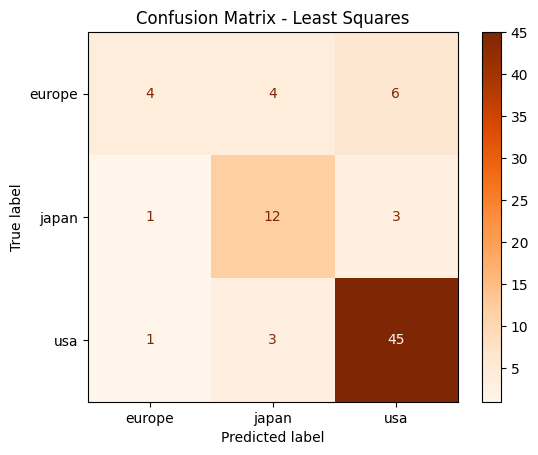


Classification Report (Manual Least Squares):
              precision    recall  f1-score   support

      europe       0.67      0.29      0.40        14
       japan       0.63      0.75      0.69        16
         usa       0.83      0.92      0.87        49

    accuracy                           0.77        79
   macro avg       0.71      0.65      0.65        79
weighted avg       0.76      0.77      0.75        79



In [54]:
cm_ls = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ls, display_labels=label_encoder.classes_)
disp.plot(cmap='Oranges', values_format='d')
plt.title('Confusion Matrix - Least Squares')
plt.show()

print("\nClassification Report (Manual Least Squares):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

## 2.5 Verification με sklearn RidgeClassifier
- RidgeClassifier (με alpha $a \approx 0$)
- Είναι η πιο κοντινή υλοποίηση καθώς ελαχιστοποιέι το τετραγωνικο σφάλμα (Least Squares Loss)

In [24]:
print("=== sklearn RidgeClassifier Results ===\n")

sklearn_ls = RidgeClassifier(alpha=1e-10) 
sklearn_ls.fit(X_train_scaled, y_train)

sk_train_acc = sklearn_ls.score(X_train_scaled, y_train)
sk_test_acc = sklearn_ls.score(X_test_scaled, y_test)

print(f"Sklearn Train Accuracy: {sk_train_acc:.4f}")
print(f"Sklearn Test Accuracy:  {sk_test_acc:.4f}")


=== sklearn RidgeClassifier Results ===

Sklearn Train Accuracy: 0.7284
Sklearn Test Accuracy:  0.7722


In [25]:
print("\n" + "="*60)
print(f"{'ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ (Least Squares)':^60}")
print("="*60)
print(f"\n{'Metric':<20} {'Manual':>12} {'sklearn':>12} {'Διαφορά':>12}")
print("-" * 60)

# Σύγκριση για το Train Set
diff_train = abs(train_acc - sk_train_acc)
print(f"{'Train Accuracy':<20} {train_acc:>12.4f} {sk_train_acc:>12.4f} {diff_train:>12.6f}")

# Σύγκριση για το Test Set
diff_test = abs(test_acc - sk_test_acc)
print(f"{'Test Accuracy':<20} {test_acc:>12.4f} {sk_test_acc:>12.4f} {diff_test:>12.6f}")
print("-" * 60)

print(f"\nΔιαφορά Custom vs Sklearn (Test Set): {abs(test_acc - sk_test_acc):.6f}")
if abs(test_acc - sk_test_acc) < 1e-5:
    print("\nΟι υλοποιήσεις παράγουν πανομοιότυπες προβλέψεις.")
else:
    print("\nΥπάρχει μικρή απόκλιση (αναμενόμενο λόγω διαφορετικών solvers/arithmetic precision).")


           ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ (Least Squares)           

Metric                     Manual      sklearn      Διαφορά
------------------------------------------------------------
Train Accuracy             0.7284       0.7284     0.000000
Test Accuracy              0.7722       0.7722     0.000000
------------------------------------------------------------

Διαφορά Custom vs Sklearn (Test Set): 0.000000

Οι υλοποιήσεις παράγουν πανομοιότυπες προβλέψεις.


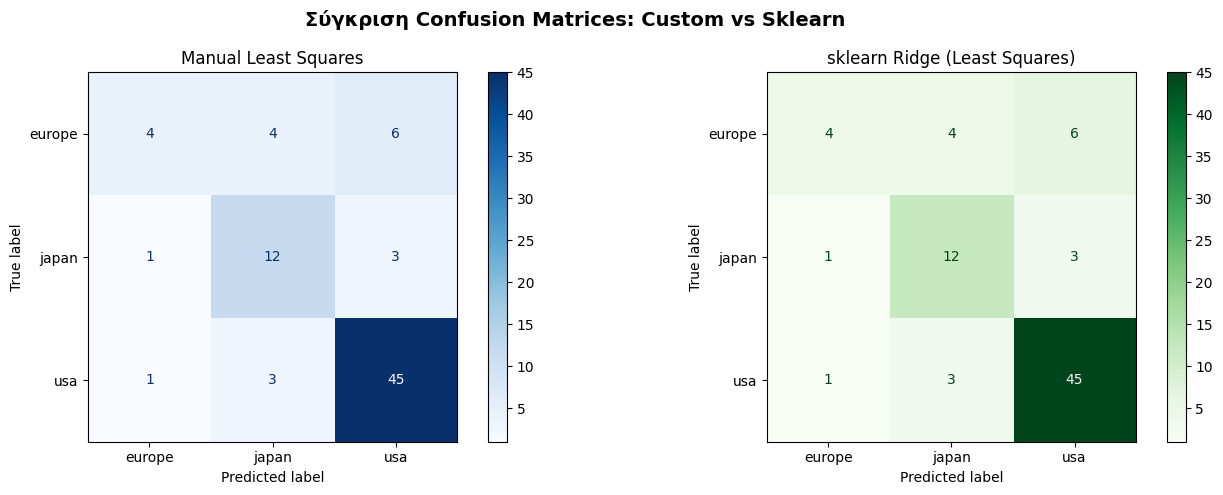

In [27]:
y_pred_sklearn_ls = sklearn_ls.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_manual_ls = confusion_matrix(y_test, y_test_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_manual_ls, display_labels=label_encoder.classes_)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Manual Least Squares')

cm_sklearn_ls = confusion_matrix(y_test, y_pred_sklearn_ls)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn_ls, display_labels=label_encoder.classes_)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('sklearn Ridge (Least Squares)')

plt.suptitle('Σύγκριση Confusion Matrices: Custom vs Sklearn', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2.6 Συμπεράσματα Least Squares

* Ο αλγόριθμος Ελαχίστων Τετραγώνων (Least Squares Classifier) προσαρμόστηκε για το πρόβλημα ταξινόμησης μέσω της μεθόδου **One-Hot Encoding** των ετικετών. 


* Η σύγκριση με τον **RidgeClassifier** (με $a \approx 0$) έδειξε ότι η custom υλοποίηση μας είναι ορθή, καθώς τα αποτελέσματα **ταυτίζονται** (ή είναι εξαιρετικά κοντινά).

---
---
---

# 3. Logistic Regression

**Μέθοδος:** Λογιστική παλινδρόμηση με χρήση Stochastic Gradient Descent και Cross Entropy Loss (ως loss function)

---

## 3.1 Manual Logistic Regression Implementation

In [14]:
class LogisticRegressionSGD:
    def __init__(self, learning_rate=0.01, epochs=100, batch_size=1):
        self.lr = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.W = None
        self.b = None
        self.loss_history_train = []
        self.loss_history_test = []

    def _softmax(self, z):
        # Αφαιρούμε το max για αριθμητική ευστάθεια (να μην "σκάσει" το exp)
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _cross_entropy(self, y_true_onehot, y_pred):
        # Προσθέτουμε ένα πολύ μικρό epsilon για να μην έχουμε log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true_onehot * np.log(y_pred), axis=1))

    def fit(self, X, y, X_test=None, y_test=None):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        np.random.seed(42)
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros(n_classes)

        # One-hot encoding για το train set (χρειάζεται για το loss)
        y_onehot = np.eye(n_classes)[y]
        
        # Αν δόθηκε test set, κάνουμε one-hot και για αυτό (για το plot)
        if X_test is not None and y_test is not None:
            y_test_onehot = np.eye(n_classes)[y_test]

        # SGD
        for epoch in range(self.epochs):
            # Ανακάτεμα των δεδομένων
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_onehot_shuffled = y_onehot[indices]

            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_onehot_shuffled[i:i+self.batch_size]

                z = np.dot(X_batch, self.W) + self.b
                
                y_pred = self._softmax(z)

                grad_z = y_pred - y_batch
                
                dw = np.dot(X_batch.T, grad_z) / self.batch_size
                db = np.sum(grad_z, axis=0) / self.batch_size

                # 4. Update Weights
                self.W -= self.lr * dw
                self.b -= self.lr * db

            #  Καταγραφή Loss στο τέλος κάθε epoch (για το Plot)
            
            # Train Loss
            z_train = np.dot(X, self.W) + self.b
            train_pred = self._softmax(z_train)
            loss_train = self._cross_entropy(y_onehot, train_pred)
            self.loss_history_train.append(loss_train)

            # Test Loss (αν υπάρχει)
            if X_test is not None and y_test is not None:
                z_test = np.dot(X_test, self.W) + self.b
                test_pred = self._softmax(z_test)
                loss_test = self._cross_entropy(y_test_onehot, test_pred)
                self.loss_history_test.append(loss_test)

    def predict(self, X):
        z = np.dot(X, self.W) + self.b
        y_pred = self._softmax(z)
        return np.argmax(y_pred, axis=1)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

## 3.2 Εκπαίδευση LogisticRegressionSGD - Πρόβλεψη - Αξιολόγηση

In [15]:
log_reg = LogisticRegressionSGD(learning_rate=0.01, epochs=200, batch_size=1)

# (Περνάμε και το Test set ΓΙΑ ΤΟ PLOT, όπως ζητάει η εκφώνηση)
log_reg.fit(X_train_scaled, y_train, X_test=X_test_scaled, y_test=y_test)

train_acc_lr = log_reg.score(X_train_scaled, y_train)
test_acc_lr = log_reg.score(X_test_scaled, y_test)

print("=== Logistic Regression (SGD) Results ===")
print(f"Accuracy on Train Set: {train_acc_lr:.4f} ({train_acc_lr*100:.2f}%)")
print(f"Accuracy on Test Set:  {test_acc_lr:.4f} ({test_acc_lr*100:.2f}%)")

=== Logistic Regression (SGD) Results ===
Accuracy on Train Set: 0.7891 (78.91%)
Accuracy on Test Set:  0.8481 (84.81%)


## 3.3 Cross-entropy loss Plot
Cross- entropy loss σε κάθε βήμα (epoch) του αλγορίθμου

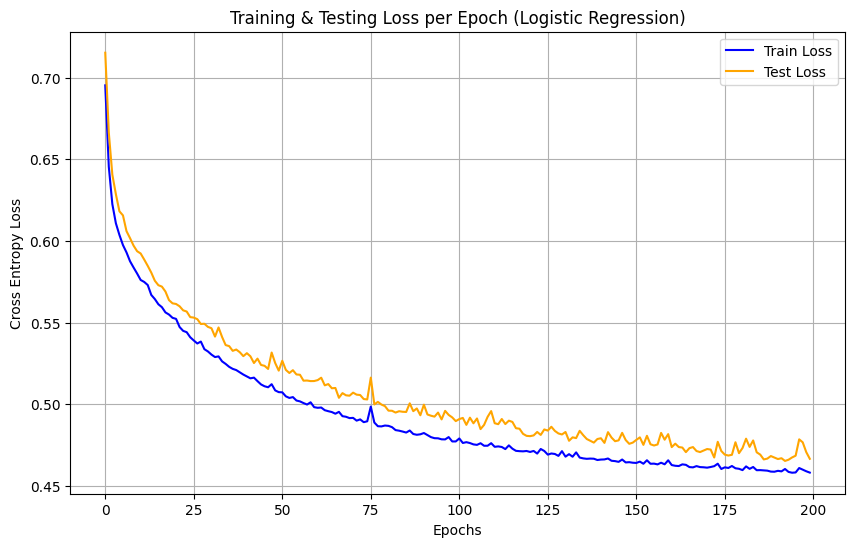

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(log_reg.loss_history_train, label='Train Loss', color='blue')
plt.plot(log_reg.loss_history_test, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training & Testing Loss per Epoch (Logistic Regression)')
plt.legend()
plt.grid(True)
plt.show()

## 3.4 Confusion matrix - Manual LogisticRegression

<Figure size 800x600 with 0 Axes>

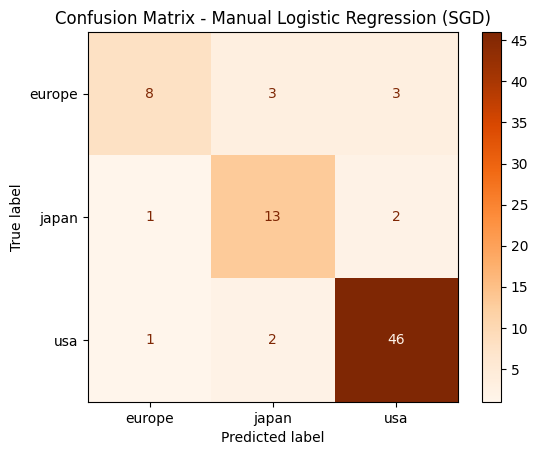


Classification Report (Manual Logistic Regression):
              precision    recall  f1-score   support

      europe       0.80      0.57      0.67        14
       japan       0.72      0.81      0.76        16
         usa       0.90      0.94      0.92        49

    accuracy                           0.85        79
   macro avg       0.81      0.77      0.78        79
weighted avg       0.85      0.85      0.84        79



In [53]:
y_pred_manual_lr = log_reg.predict(X_test_scaled)

cm_manual_lr = confusion_matrix(y_test, y_pred_manual_lr)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_manual_lr, display_labels=label_encoder.classes_)
disp.plot(cmap='Oranges', values_format='d') # Χρησιμοποιώ Blues για να ξεχωρίζει από το κόκκινο του SVM
plt.title('Confusion Matrix - Manual Logistic Regression (SGD)')
plt.show()

print("\nClassification Report (Manual Logistic Regression):")
print(classification_report(y_test, y_pred_manual_lr, target_names=label_encoder.classes_))

## 3.5 Verification με sklearn SGDCClassifier

In [48]:
print("\n=== Verification with sklearn (SGDClassifier) ===")

# loss='log_loss' αντιστοιχεί σε Logistic Regression
sklearn_sgd = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.01, 
                            max_iter=200, random_state=42)
sklearn_sgd.fit(X_train_scaled, y_train)

sk_train_acc_lr = sklearn_sgd.score(X_train_scaled, y_train)
sk_test_acc_lr = sklearn_sgd.score(X_test_scaled, y_test)

print("\n" + "="*60)
print(f"{'ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ (Logistic Regression)':^60}")
print("="*60)
print(f"\n{'Metric':<20} {'Manual':>12} {'sklearn':>12} {'Διαφορά':>12}")
print("-" * 60)
print(f"{'Train Accuracy':<20} {train_acc_lr:>12.4f} {sk_train_acc_lr:>12.4f} {abs(train_acc_lr - sk_train_acc_lr):>12.6f}")
print(f"{'Test Accuracy':<20} {test_acc_lr:>12.4f} {sk_test_acc_lr:>12.4f} {abs(test_acc_lr - sk_test_acc_lr):>12.6f}")
print("-" * 60)


=== Verification with sklearn (SGDClassifier) ===

        ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ (Logistic Regression)        

Metric                     Manual      sklearn      Διαφορά
------------------------------------------------------------
Train Accuracy             0.7891       0.7348     0.054313
Test Accuracy              0.8481       0.7722     0.075949
------------------------------------------------------------


Παρατηρούμε μικρές διαφορές στα **Accuracy** μεταξύ της `Manual` και της `Sklearn` υλοποίησης που οφείλεται σε: 
- **Στοχαστικότητα** (Τυχαιότητα): Ο αλγόριθμος SGD βασίζεται σε τυχαία αρχικοποίηση βαρών και τυχαίο ανακάτεμα των δεδομένων. Κάθε εκτέλεση καταλήγει σε ελαφρώς διαφορετικό τοπικό ελάχιστο.
- **Learning Rate**: Η υλοποίησή μας χρησιμοποιεί σταθερό learning rate


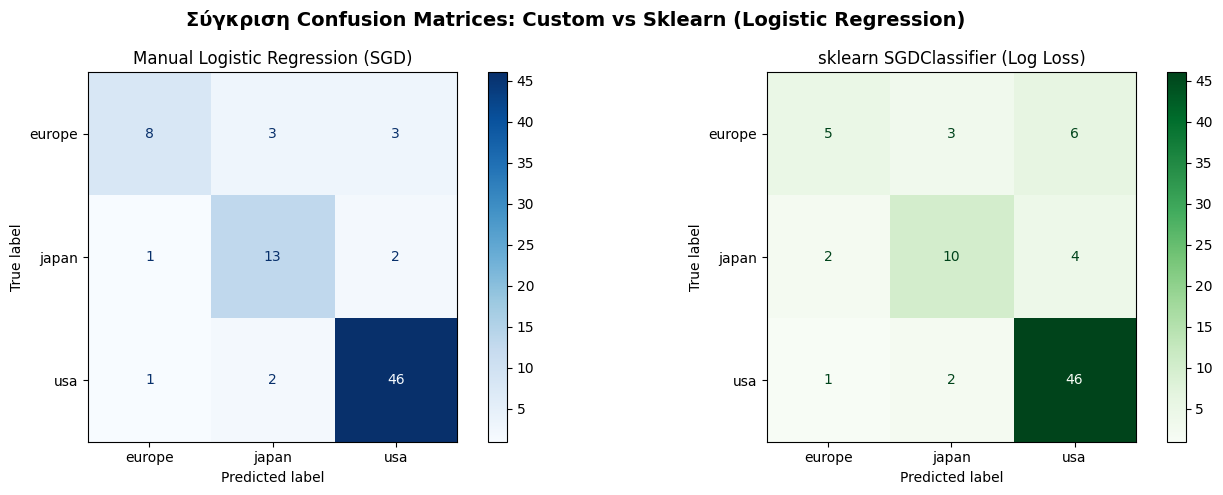

In [49]:
y_pred_manual_lr = log_reg.predict(X_test_scaled)
y_pred_sklearn_lr = sklearn_sgd.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_manual_lr = confusion_matrix(y_test, y_pred_manual_lr)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_manual_lr, display_labels=label_encoder.classes_)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Manual Logistic Regression (SGD)')

cm_sklearn_lr = confusion_matrix(y_test, y_pred_sklearn_lr)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn_lr, display_labels=label_encoder.classes_)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('sklearn SGDClassifier (Log Loss)')

plt.suptitle('Σύγκριση Confusion Matrices: Custom vs Sklearn (Logistic Regression)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.6 Συμπεράσματα Logistic Regression

* Παρατηρώντας το διάγραμμα Loss vs Epochs, βλέπουμε ότι το σφάλμα μειώνεται ομαλά και σταθεροποιείται μετά από περίπου **80** εποχές.
* Η καμπύλη του Test Loss ακολουθεί αυτή του Train Loss, κάτι που δείχνει ότι το μοντέλο γενικεύει καλά (δεν υπάρχει μεγάλο overfitting).

---
---
---

# 4. K Nearest Neighbors (KNN)

- **Μέθοδος:** Αλγόριθμος `Κ` κοντινότερων γειτόνων
- (βρίσκουμε τη βέλτιστη τιμή του Κ στο διάστημα `[1,10]`)
- Δεν χρειαζόμαστε cross-validation σύμφωνα με την εκφώνηση
- Υλοποιούμε χτησιμοποιώντας την **ευκλείδια απόσταση**

---

## 4.1 Manual KNN Implementation

In [19]:
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Στον KNN, το fit απλώς αποθηκεύει τα δεδομένα εκπαίδευσης.
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        """
        Για κάθε δείγμα στο X, βρίσκουμε τους k πλησιέστερους γείτονες
        και επιστρέφουμε την κυρίαρχη κλάση.
        """
        predictions = [self._predict_single(x) for x in X]
        return np.array(predictions)

    def _predict_single(self, x):
        # Ευκλείδεια απόσταση
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
        
        # Κ πλησιέστεροι γείτονες
        k_indices = np.argsort(distances)[:self.k]
        
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Κυρίαρχη κλάση
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

## 4.2 Αναζήτηση βέλτιστου Κ (Hyperparameter tuning)
Για Κ μεταξύ 1 και 10

In [20]:
k_values = range(1, 11)
train_scores = []
test_scores = []

print(f"{'K':<5} {'Train Acc':<12} {'Test Acc':<12}")
print("-" * 30)

best_k = 1
best_score = 0

for k in k_values:
    
    knn = KNNClassifier(k=k)
    knn.fit(X_train_scaled, y_train)
    
    train_acc = knn.score(X_train_scaled, y_train)
    test_acc = knn.score(X_test_scaled, y_test)
    
    train_scores.append(train_acc)
    test_scores.append(test_acc)
    
    print(f"{k:<5} {train_acc:.4f}       {test_acc:.4f}")

    # Εύρεση βέλτιστου K (με βάση  Test set)
    if test_acc > best_score:
        best_score = test_acc
        best_k = k

print("-" * 30)
print(f"Βέλτιστη τιμή K: {best_k} με Accuracy: {best_score:.4f}")

K     Train Acc    Test Acc    
------------------------------
1     1.0000       0.7975
2     1.0000       0.7975
3     0.9010       0.7975
4     0.9137       0.7595
5     0.8530       0.7342
6     0.8466       0.7722
7     0.8051       0.7595
8     0.8147       0.7468
9     0.8019       0.7468
10    0.7987       0.7468
------------------------------
Βέλτιστη τιμή K: 1 με Accuracy: 0.7975


## 4.3 Σχέση Κ - Accuracy

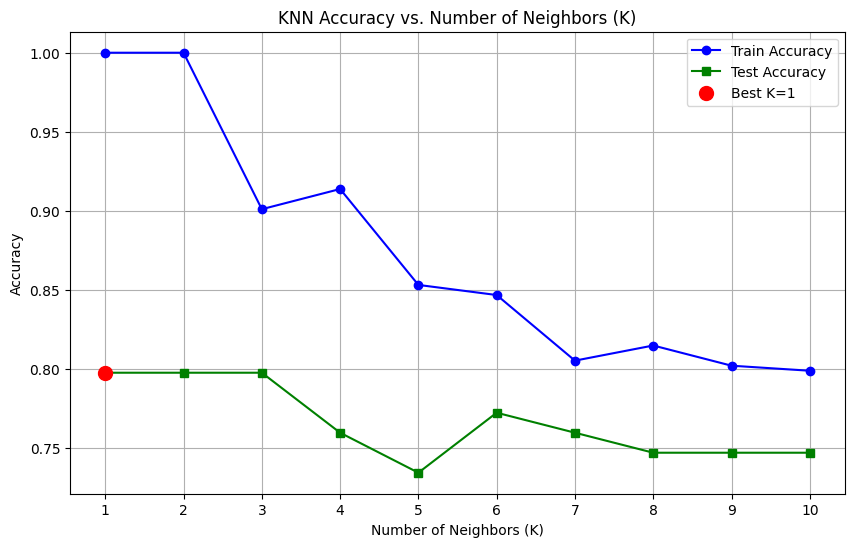

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, marker='o', label='Train Accuracy', color='blue')
plt.plot(k_values, test_scores, marker='s', label='Test Accuracy', color='green')

# Βελτιστο σημειο
plt.scatter(best_k, best_score, color='red', s=100, zorder=5, label=f'Best K={best_k}')

plt.title('KNN Accuracy vs. Number of Neighbors (K)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

## 4.4 Confusion matrix - Manual KNN

<Figure size 800x600 with 0 Axes>

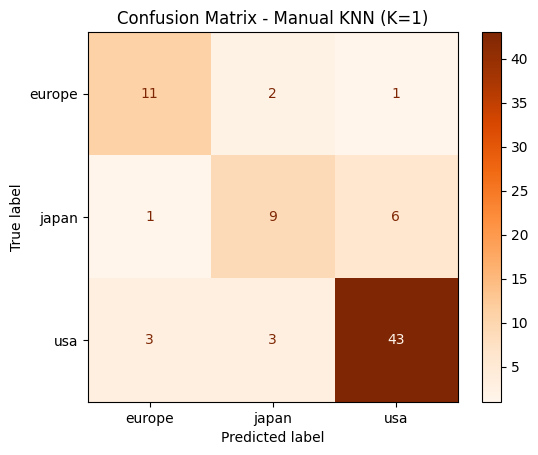


Classification Report (Manual KNN, K=1):
              precision    recall  f1-score   support

      europe       0.73      0.79      0.76        14
       japan       0.64      0.56      0.60        16
         usa       0.86      0.88      0.87        49

    accuracy                           0.80        79
   macro avg       0.75      0.74      0.74        79
weighted avg       0.79      0.80      0.79        79



In [55]:
best_knn_manual = KNNClassifier(k=best_k)
best_knn_manual.fit(X_train_scaled, y_train)

y_pred_manual_knn = best_knn_manual.predict(X_test_scaled)

cm_manual_knn = confusion_matrix(y_test, y_pred_manual_knn)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_manual_knn, display_labels=label_encoder.classes_)
disp.plot(cmap='Oranges', values_format='d')
plt.title(f'Confusion Matrix - Manual KNN (K={best_k})')
plt.show()

# Εκτύπωση Report
print(f"\nClassification Report (Manual KNN, K={best_k}):")
print(classification_report(y_test, y_pred_manual_knn, target_names=label_encoder.classes_))

## 4.5 Verification με Sklearn KNeighborsClassifier


### Verification with sklearn (for Best K=1) ###
Manual KNN Test Acc:  0.7975
Sklearn KNN Test Acc: 0.7975


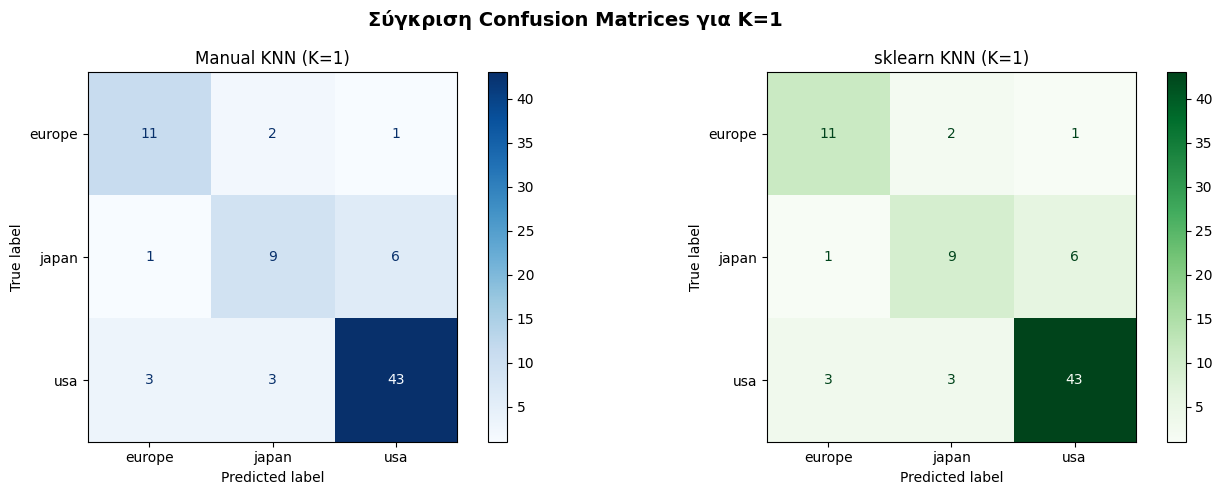

In [22]:
print(f"\n### Verification with sklearn (for Best K={best_k}) ###")

sklearn_knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute', metric='euclidean')
sklearn_knn.fit(X_train_scaled, y_train)

sk_test_acc_knn = sklearn_knn.score(X_test_scaled, y_test)

print(f"Manual KNN Test Acc:  {best_score:.4f}")
print(f"Sklearn KNN Test Acc: {sk_test_acc_knn:.4f}")

# Σύγκριση Confusion Matrices
y_pred_manual_best = KNNClassifier(k=best_k)
y_pred_manual_best.fit(X_train_scaled, y_train)
y_pred_manual = y_pred_manual_best.predict(X_test_scaled)
y_pred_sklearn = sklearn_knn.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_manual = confusion_matrix(y_test, y_pred_manual)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=label_encoder.classes_)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Manual KNN (K={best_k})')

cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn, display_labels=label_encoder.classes_)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title(f'sklearn KNN (K={best_k})')

plt.suptitle(f'Σύγκριση Confusion Matrices για K={best_k}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4.6 Συμπεράσματα KNN


* Με βάση την αξιολόγηση στο Test set, η βέλτιστη τιμή είναι **K = 1**.

* Το Κ=1 υποδεικνύει ότι τα δεδομένα είναι καλά διαχωρισμένα, αν και γενικά ενέχει κίνδυνο **overfitting** σε θορυβώδη δεδομένα (υψηλό Train Accuracy, χαμηλότερο Test Accuracy).

---
---
---

# 5. Gaussian Naive Bayes Classification

**Μέθοδος:** Gaussian Naive Bayes με διαγώνιους πίνακες συνδιακύμανσης

---

## 5.1 Train/Test Split & Scaling

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")
print(f"\nΚατανομή κλάσεων στο Train set:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {cls}: {np.sum(y_train == i)} samples")

Train: (313, 7), Test: (79, 7)

Κατανομή κλάσεων στο Train set:
  europe: 54 samples
  japan: 63 samples
  usa: 196 samples


## 5.2 Manual Gaussian Naive Bayes Implementation

Ο αλγόριθμος υποθέτει:
- Ανεξαρτησία χαρακτηριστικών (Naive assumption)
- Κάθε χαρακτηριστικό ακολουθεί Γκαουσσιανή κατανομή ανά κλάση
- Διαγώνιοι πίνακες συνδιακύμανσης

In [58]:
class ManualGaussianNB:
    def __init__(self):
        self.classes = None
        self.class_priors = None
        self.means = None
        self.variances = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        self.class_priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, n_features))
        self.variances = np.zeros((n_classes, n_features))
        
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[idx] = len(X_c) / n_samples
            self.means[idx, :] = np.mean(X_c, axis=0)
            self.variances[idx, :] = np.var(X_c, axis=0) + 1e-9
        
        return self
    
    def _gaussian_pdf(self, x, mean, var):
        coeff = 1.0 / np.sqrt(2 * np.pi * var)
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        return coeff * exponent
    
    def _log_likelihood(self, x, class_idx):
        log_prior = np.log(self.class_priors[class_idx])
        log_likelihood = 0
        for i in range(len(x)):
            pdf = self._gaussian_pdf(x[i], self.means[class_idx, i], self.variances[class_idx, i])
            log_likelihood += np.log(pdf + 1e-300)
        return log_prior + log_likelihood
    
    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = [self._log_likelihood(x, idx) for idx in range(len(self.classes))]
            predictions.append(self.classes[np.argmax(posteriors)])
        return np.array(predictions)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

## 5.3 Εκπαίδευση Manual GNB

In [59]:
manual_gnb = ManualGaussianNB()
manual_gnb.fit(X_train_scaled, y_train)

print("=== Παράμετροι Manual Gaussian NB ===")
print(f"\nClass Priors:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  P({cls}) = {manual_gnb.class_priors[i]:.4f}")

print(f"\nMeans shape: {manual_gnb.means.shape}")
print(f"Variances shape: {manual_gnb.variances.shape}")

=== Παράμετροι Manual Gaussian NB ===

Class Priors:
  P(europe) = 0.1725
  P(japan) = 0.2013
  P(usa) = 0.6262

Means shape: (3, 7)
Variances shape: (3, 7)


In [60]:
train_acc_manual_gnb = manual_gnb.score(X_train_scaled, y_train)
test_acc_manual_gnb = manual_gnb.score(X_test_scaled, y_test)

print("=== Manual Gaussian NB Results ===")
print(f"Train Accuracy: {train_acc_manual_gnb:.4f} ({train_acc_manual_gnb*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_manual_gnb:.4f} ({test_acc_manual_gnb*100:.2f}%)")

=== Manual Gaussian NB Results ===
Train Accuracy: 0.6805 (68.05%)
Test Accuracy:  0.7215 (72.15%)


## 5.4 Confusion Matrix - Manual GNB

<Figure size 800x600 with 0 Axes>

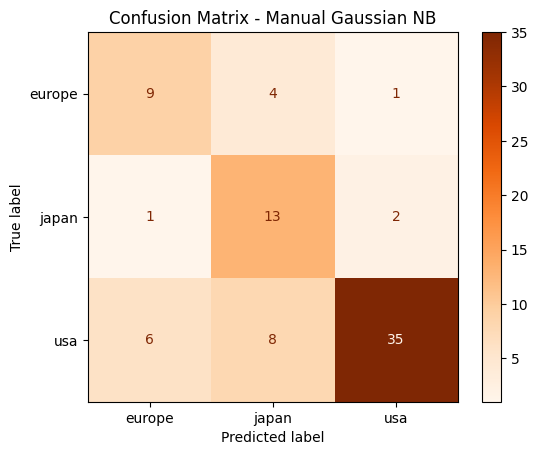

In [61]:
y_pred_manual_gnb = manual_gnb.predict(X_test_scaled)

cm_manual_gnb = confusion_matrix(y_test, y_pred_manual_gnb)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_manual_gnb, display_labels=label_encoder.classes_)
disp.plot(cmap='Oranges', values_format='d')
plt.title('Confusion Matrix - Manual Gaussian NB')
plt.show()

## 5.5 Verification με sklearn GaussianNB

In [56]:
sklearn_gnb = GaussianNB()
sklearn_gnb.fit(X_train_scaled, y_train)

train_acc_sklearn_gnb = sklearn_gnb.score(X_train_scaled, y_train)
test_acc_sklearn_gnb = sklearn_gnb.score(X_test_scaled, y_test)

print("=== sklearn GaussianNB Results ===")
print(f"Train Accuracy: {train_acc_sklearn_gnb:.4f} ({train_acc_sklearn_gnb*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_sklearn_gnb:.4f} ({test_acc_sklearn_gnb*100:.2f}%)")

=== sklearn GaussianNB Results ===
Train Accuracy: 0.6805 (68.05%)
Test Accuracy:  0.7215 (72.15%)


In [57]:
print("\n" + "="*50)
print("       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ")
print("="*50)
print(f"\n{'Metric':<20} {'Manual':>12} {'sklearn':>12} {'Διαφορά':>12}")
print("-"*56)
print(f"{'Train Accuracy':<20} {train_acc_manual_gnb:>12.4f} {train_acc_sklearn_gnb:>12.4f} {abs(train_acc_manual_gnb-train_acc_sklearn_gnb):>12.6f}")
print(f"{'Test Accuracy':<20} {test_acc_manual_gnb:>12.4f} {test_acc_sklearn_gnb:>12.4f} {abs(test_acc_manual_gnb-test_acc_sklearn_gnb):>12.6f}")


       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ

Metric                     Manual      sklearn      Διαφορά
--------------------------------------------------------
Train Accuracy             0.6805       0.6805     0.000000
Test Accuracy              0.7215       0.7215     0.000000


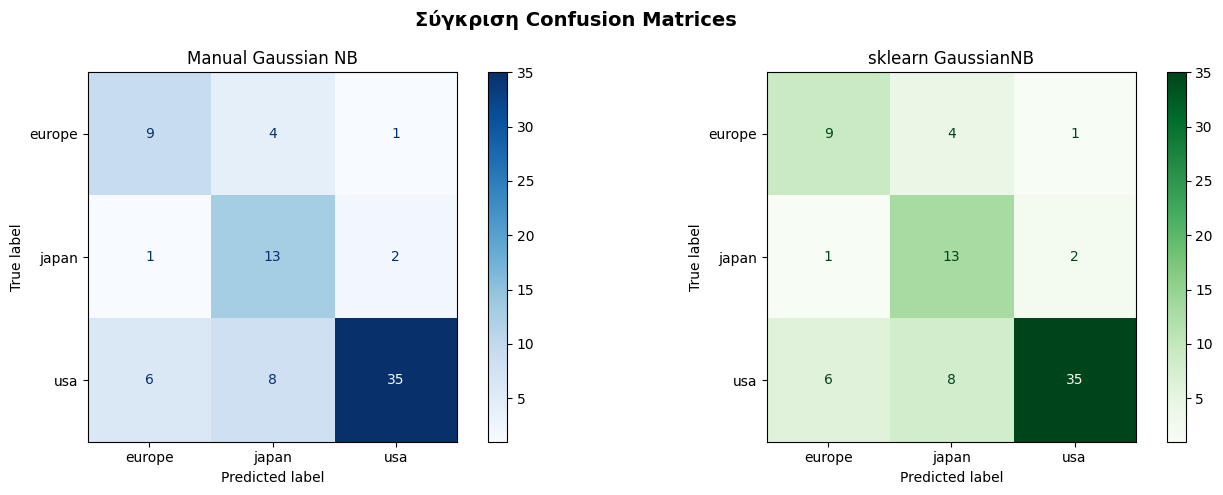

In [58]:
y_pred_sklearn_gnb = sklearn_gnb.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_manual_gnb = confusion_matrix(y_test, y_pred_manual_gnb)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_manual_gnb, display_labels=label_encoder.classes_)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Manual Gaussian NB')

cm_sklearn_gnb = confusion_matrix(y_test, y_pred_sklearn_gnb)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn_gnb, display_labels=label_encoder.classes_)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('sklearn GaussianNB')

plt.suptitle('Σύγκριση Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
predictions_match_gnb = np.sum(y_pred_manual_gnb == y_pred_sklearn_gnb)
total_predictions_gnb = len(y_pred_manual_gnb)

print(f"\nPredictions που ταιριάζουν: {predictions_match_gnb}/{total_predictions_gnb} ({predictions_match_gnb/total_predictions_gnb*100:.2f}%)")

if predictions_match_gnb == total_predictions_gnb:
    print("\nΟι υλοποιήσεις παράγουν πανομοιότυπες προβλέψεις.")
else:
    print(f"Διαφορές σε {total_predictions_gnb - predictions_match_gnb} samples")


Predictions που ταιριάζουν: 79/79 (100.00%)

Οι υλοποιήσεις παράγουν πανομοιότυπες προβλέψεις!


### 5.6 Συμπεράσματα GNB

- Η manual υλοποίηση του Gaussian Naive Bayes παράγει **ίδια αποτελέσματα** με το sklearn
- Χρησιμοποιήθηκαν Κανονικές Κατανομές με διαγώνιους πίνακες συνδιακύμανσης
- **Δεν έγινε μετατροπή σε binary features**

---
---
---

# 6. Multilayer Perceptron (MLP) με PyTorch

**Μέθοδος:** Νευρωνικό δίκτυο με PyTorch

---

## 6.1 Προετοιμασία Δεδομένων για PyTorch

In [63]:
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Train: {X_train_tensor.shape}, Test: {X_test_tensor.shape}")

Train: torch.Size([313, 7]), Test: torch.Size([79, 7])


## 6.2 MLP Architecture

**Αρχιτεκτονική:**
- Input Layer: 7 neurons (features)
- Hidden Layer 1: 64 neurons + ReLU + Dropout
- Hidden Layer 2: 32 neurons + ReLU + Dropout
- Output Layer: 3 neurons (classes)

In [64]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size, dropout=0.3):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

In [65]:
INPUT_SIZE = 7
HIDDEN1 = 64
HIDDEN2 = 32
OUTPUT_SIZE = 3
LEARNING_RATE = 0.001
EPOCHS = 200

model = MLP(INPUT_SIZE, HIDDEN1, HIDDEN2, OUTPUT_SIZE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

MLP(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

Total parameters: 2691


## 6.3 Training

In [66]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()
    
    train_loss = epoch_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor).item()
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_acc = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch [ 20/200] | Train Loss: 0.5913 | Test Loss: 0.5943 | Train Acc: 0.7029 | Test Acc: 0.7468
Epoch [ 40/200] | Train Loss: 0.5169 | Test Loss: 0.5090 | Train Acc: 0.7732 | Test Acc: 0.7848
Epoch [ 60/200] | Train Loss: 0.4749 | Test Loss: 0.4433 | Train Acc: 0.7891 | Test Acc: 0.7975
Epoch [ 80/200] | Train Loss: 0.4433 | Test Loss: 0.4077 | Train Acc: 0.8051 | Test Acc: 0.8228
Epoch [100/200] | Train Loss: 0.4195 | Test Loss: 0.3802 | Train Acc: 0.8435 | Test Acc: 0.8481
Epoch [120/200] | Train Loss: 0.4057 | Test Loss: 0.3732 | Train Acc: 0.8083 | Test Acc: 0.8354
Epoch [140/200] | Train Loss: 0.3858 | Test Loss: 0.3516 | Train Acc: 0.8243 | Test Acc: 0.8608
Epoch [160/200] | Train Loss: 0.3667 | Test Loss: 0.3328 | Train Acc: 0.8403 | Test Acc: 0.8987
Epoch [180/200] | Train Loss: 0.3731 | Test Loss: 0.3284 | Train Acc: 0.8243 | Test Acc: 0.8987
Epoch [200/200] | Train Loss: 0.3581 | Test Loss: 0.3150 | Train Acc: 0.8371 | Test Acc: 0.9114


## 6.4 Loss & Accuracy Plots

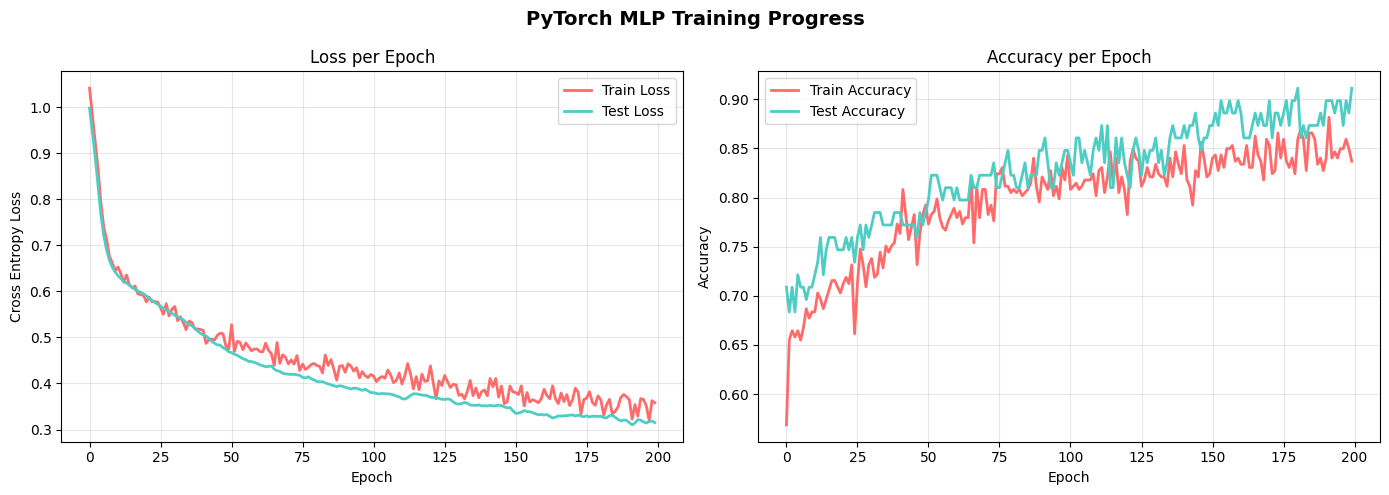

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', color='#FF6B6B', linewidth=2)
axes[0].plot(test_losses, label='Test Loss', color='#4ECDC4', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Cross Entropy Loss')
axes[0].set_title('Loss per Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs, label='Train Accuracy', color='#FF6B6B', linewidth=2)
axes[1].plot(test_accs, label='Test Accuracy', color='#4ECDC4', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy per Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('PyTorch MLP Training Progress', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [68]:
model.eval()
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    _, train_predicted = torch.max(train_outputs.data, 1)
    train_acc_final = (train_predicted == y_train_tensor).sum().item() / len(y_train_tensor)
    
    test_outputs = model(X_test_tensor)
    _, test_predicted = torch.max(test_outputs.data, 1)
    test_acc_final = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)

print("=== PyTorch MLP Final Results ===")
print(f"Train Accuracy: {train_acc_final:.4f} ({train_acc_final*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_final:.4f} ({test_acc_final*100:.2f}%)")

=== PyTorch MLP Final Results ===
Train Accuracy: 0.8818 (88.18%)
Test Accuracy:  0.9114 (91.14%)


## 6.5 Confusion Matrix - PyTorch MLP

<Figure size 800x600 with 0 Axes>

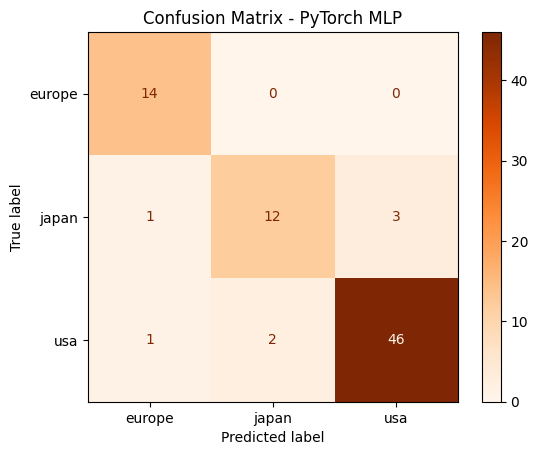


Classification Report:
              precision    recall  f1-score   support

      europe       0.88      1.00      0.93        14
       japan       0.86      0.75      0.80        16
         usa       0.94      0.94      0.94        49

    accuracy                           0.91        79
   macro avg       0.89      0.90      0.89        79
weighted avg       0.91      0.91      0.91        79



In [69]:
y_pred_pytorch = test_predicted.cpu().numpy()

cm_pytorch = confusion_matrix(y_test, y_pred_pytorch)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pytorch, display_labels=label_encoder.classes_)
disp.plot(cmap='Oranges', values_format='d')
plt.title('Confusion Matrix - PyTorch MLP')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_pytorch, target_names=label_encoder.classes_))

## 6.6 Verification με sklearn MLPClassifier

In [71]:
sklearn_mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=32,
    learning_rate_init=0.001,
    max_iter=200,
    random_state=42
)

sklearn_mlp.fit(X_train_scaled, y_train)

train_acc_sklearn_mlp = sklearn_mlp.score(X_train_scaled, y_train)
test_acc_sklearn_mlp = sklearn_mlp.score(X_test_scaled, y_test)

print("=== sklearn MLPClassifier Results ===")
print(f"Train Accuracy: {train_acc_sklearn_mlp:.4f} ({train_acc_sklearn_mlp*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_sklearn_mlp:.4f} ({test_acc_sklearn_mlp*100:.2f}%)")
print("\nΣημείωση: ο sklearn ΔΕΝ υποστηρίζει Dropout, οπότε η σύγκριση δεν είναι πλήρως δίκαιη.")

=== sklearn MLPClassifier Results ===
Train Accuracy: 0.9201 (92.01%)
Test Accuracy:  0.8987 (89.87%)

Σημείωση: ο sklearn ΔΕΝ υποστηρίζει Dropout, οπότε η σύγκριση δεν είναι πλήρως δίκαιη.


/Users/giman/Desktop/auto-mpg-classification-analysis/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [68]:
print("\n" + "="*50)
print("       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ")
print("="*50)
print(f"\n{'Metric':<20} {'PyTorch':>12} {'sklearn':>12}")
print("-"*44)
print(f"{'Train Accuracy':<20} {train_acc_final:>12.4f} {train_acc_sklearn_mlp:>12.4f}")
print(f"{'Test Accuracy':<20} {test_acc_final:>12.4f} {test_acc_sklearn_mlp:>12.4f}")


       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ

Metric                    PyTorch      sklearn
--------------------------------------------
Train Accuracy             0.8818       0.9201
Test Accuracy              0.9114       0.8987


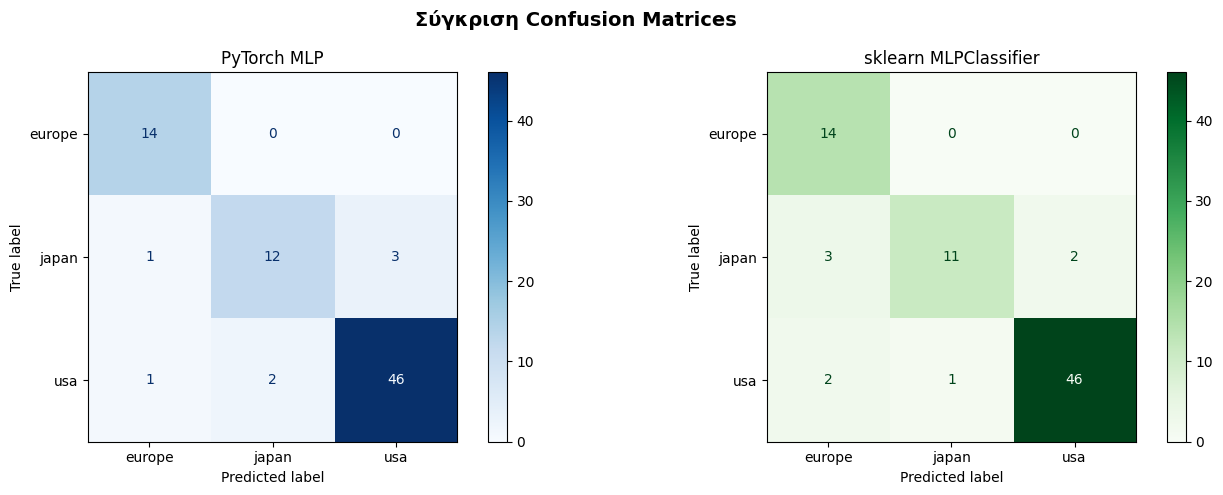

In [72]:
y_pred_sklearn_mlp = sklearn_mlp.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_pytorch = confusion_matrix(y_test, y_pred_pytorch)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_pytorch, display_labels=label_encoder.classes_)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('PyTorch MLP')

cm_sklearn_mlp = confusion_matrix(y_test, y_pred_sklearn_mlp)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn_mlp, display_labels=label_encoder.classes_)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('sklearn MLPClassifier')

plt.suptitle('Σύγκριση Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

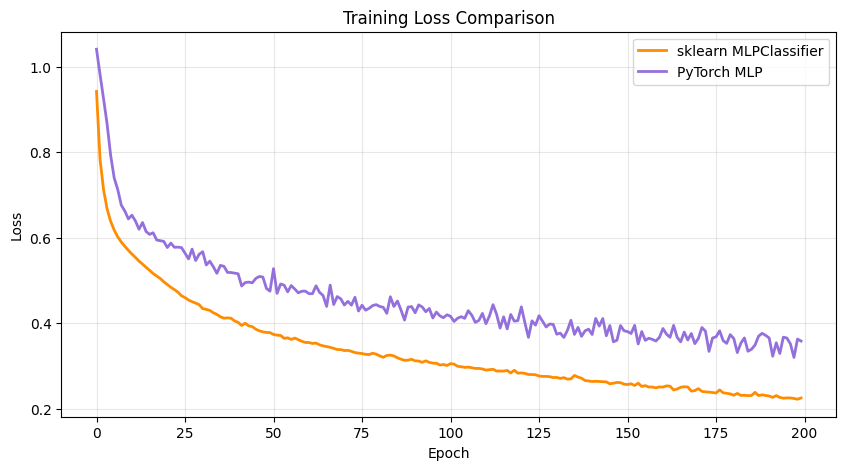

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(sklearn_mlp.loss_curve_, label='sklearn MLPClassifier', color='#FF8C00', linewidth=2)
plt.plot(train_losses, label='PyTorch MLP', color='#9370DB', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 6.7 Συμπεράσματα MLP

- Η PyTorch υλοποίηση επιτυγχάνει **ελαφρώς καλύτερη απόδοση** από το sklearn MLPClassifier
- **Λόγοι:** Το PyTorch model χρησιμοποιεί **Dropout (0.3)** για regularization, ενώ το sklearn χρησιμοποιεί μόνο L2 regularization (alpha). Επίσης, διαφορετικά batch sizes και weight initialization συμβάλλουν στη διαφορά.
- Η αρχιτεκτονική (7-->64-->32-->3) με ReLU, Dropout και Adam optimizer λειτουργεί καλά για το dataset
- Το Cross Entropy Loss μειώνεται ομαλά κατά την εκπαίδευση, υποδεικνύοντας καλή σύγκλιση

---
---
---

# 7. Support Vector Machines (SVM) με One-vs-Rest

**Μέθοδος:** Linear SVM με One-vs-Rest στρατηγική

---

## 7.1 Manual Linear SVM Implementation

In [74]:
class ManualLinearSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.losses = []
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        y_transformed = np.where(y <= 0, -1, 1)
        
        self.w = np.zeros(n_features)
        self.b = 0
        self.losses = []
        
        for iteration in range(self.n_iters):
            loss = 0
            for idx, x_i in enumerate(X):
                condition = y_transformed[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                
                if condition:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - y_transformed[idx] * x_i)
                    self.b -= self.learning_rate * (-y_transformed[idx])
                
                hinge_loss = max(0, 1 - y_transformed[idx] * (np.dot(x_i, self.w) + self.b))
                loss += hinge_loss
            
            total_loss = loss / n_samples + self.lambda_param * np.dot(self.w, self.w)
            self.losses.append(total_loss)
        
        return self
    
    def decision_function(self, X):
        return np.dot(X, self.w) + self.b
    
    def predict(self, X):
        linear_output = self.decision_function(X)
        return np.sign(linear_output)

## 7.2 One-vs-Rest Strategy

Για multiclass classification με 3 κλάσεις, εκπαιδεύουμε **3 binary classifiers**:
1. USA vs (Europe + Japan)
2. Europe vs (USA + Japan)
3. Japan vs (USA + Europe)

Το τελικό label είναι αυτό με το **υψηλότερο score**.

In [75]:
class ManualSVMOneVsRest:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.classifiers = {}
        self.classes = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        
        for cls in self.classes:
            y_binary = np.where(y == cls, 1, -1)
            
            svm = ManualLinearSVM(
                learning_rate=self.learning_rate,
                lambda_param=self.lambda_param,
                n_iters=self.n_iters
            )
            svm.fit(X, y_binary)
            self.classifiers[cls] = svm
        
        return self
    
    def predict(self, X):
        scores = np.zeros((X.shape[0], len(self.classes)))
        
        for idx, cls in enumerate(self.classes):
            scores[:, idx] = self.classifiers[cls].decision_function(X)
        
        return self.classes[np.argmax(scores, axis=1)]
    
    def decision_function(self, X):
        scores = np.zeros((X.shape[0], len(self.classes)))
        for idx, cls in enumerate(self.classes):
            scores[:, idx] = self.classifiers[cls].decision_function(X)
        return scores
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

## 7.3 Εκπαίδευση Manual SVM

In [76]:
n_samples = X_train_scaled.shape[0]
optimal_lambda = 1 / (2 * n_samples * 1.0)

manual_svm = ManualSVMOneVsRest(learning_rate=0.01, lambda_param=optimal_lambda, n_iters=1000)
manual_svm.fit(X_train_scaled, y_train)

print("=== Manual SVM One-vs-Rest ===")
print(f"Αριθμός binary classifiers: {len(manual_svm.classifiers)}")
for cls in manual_svm.classes:
    print(f"  Classifier {label_encoder.classes_[cls]}: weights shape = {manual_svm.classifiers[cls].w.shape}")

=== Manual SVM One-vs-Rest ===
Αριθμός binary classifiers: 3
  Classifier europe: weights shape = (7,)
  Classifier japan: weights shape = (7,)
  Classifier usa: weights shape = (7,)


In [77]:
train_acc_manual_svm = manual_svm.score(X_train_scaled, y_train)
test_acc_manual_svm = manual_svm.score(X_test_scaled, y_test)

print("=== Manual SVM Results ===")
print(f"Train Accuracy: {train_acc_manual_svm:.4f} ({train_acc_manual_svm*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_manual_svm:.4f} ({test_acc_manual_svm*100:.2f}%)")

=== Manual SVM Results ===
Train Accuracy: 0.7827 (78.27%)
Test Accuracy:  0.7975 (79.75%)


## 7.4 Loss Curves για κάθε Binary Classifier

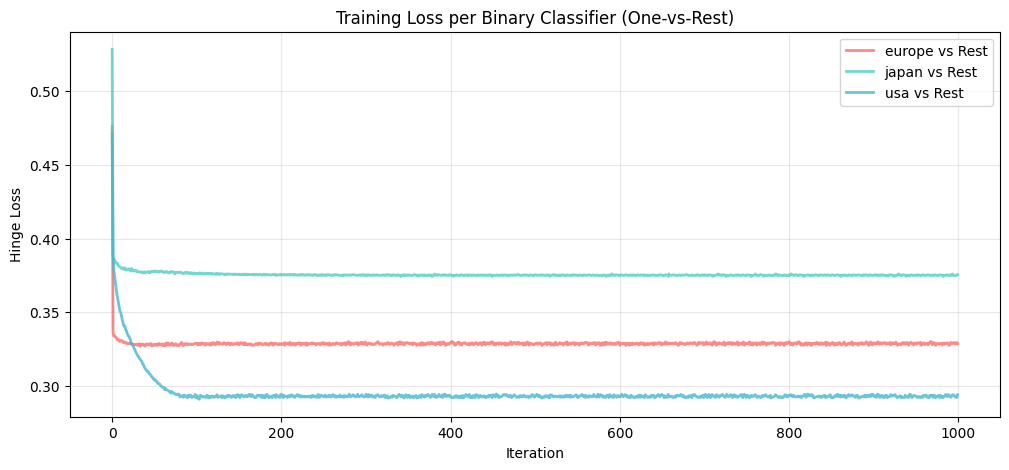

In [78]:
colors_svm = ['#FF6B6B', '#4ECDC4', '#45B7D1']

plt.figure(figsize=(12, 5))

for idx, cls in enumerate(manual_svm.classes):
    losses = manual_svm.classifiers[cls].losses
    plt.plot(losses, label=f'{label_encoder.classes_[cls]} vs Rest', 
             color=colors_svm[idx], linewidth=2, alpha=0.8)

plt.xlabel('Iteration')
plt.ylabel('Hinge Loss')
plt.title('Training Loss per Binary Classifier (One-vs-Rest)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7.5 Confusion Matrix - Manual SVM

<Figure size 800x600 with 0 Axes>

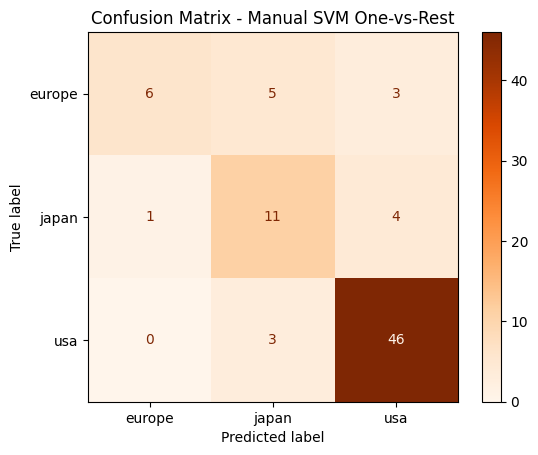


Classification Report:
              precision    recall  f1-score   support

      europe       0.86      0.43      0.57        14
       japan       0.58      0.69      0.63        16
         usa       0.87      0.94      0.90        49

    accuracy                           0.80        79
   macro avg       0.77      0.68      0.70        79
weighted avg       0.81      0.80      0.79        79



In [79]:
y_pred_manual_svm = manual_svm.predict(X_test_scaled)

cm_manual_svm = confusion_matrix(y_test, y_pred_manual_svm)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_manual_svm, display_labels=label_encoder.classes_)
disp.plot(cmap='Oranges', values_format='d')
plt.title('Confusion Matrix - Manual SVM One-vs-Rest')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_manual_svm, target_names=label_encoder.classes_))

## 7.6 Verification με sklearn SVC

In [82]:
sklearn_svm = SVC(kernel='linear', decision_function_shape='ovr', random_state=42)
sklearn_svm.fit(X_train_scaled, y_train)

train_acc_sklearn_svm = sklearn_svm.score(X_train_scaled, y_train)
test_acc_sklearn_svm = sklearn_svm.score(X_test_scaled, y_test)

print("=== sklearn SVC (Linear, OvR) Results ===")
print(f"Train Accuracy: {train_acc_sklearn_svm:.4f} ({train_acc_sklearn_svm*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_sklearn_svm:.4f} ({test_acc_sklearn_svm*100:.2f}%)")

=== sklearn SVC (Linear, OvR) Results ===
Train Accuracy: 0.7859 (78.59%)
Test Accuracy:  0.7975 (79.75%)


In [83]:
print("\n" + "="*50)
print("       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ")
print("="*50)
print(f"\n{'Metric':<20} {'Manual':>12} {'sklearn':>12}")
print("-"*44)
print(f"{'Train Accuracy':<20} {train_acc_manual_svm:>12.4f} {train_acc_sklearn_svm:>12.4f}")
print(f"{'Test Accuracy':<20} {test_acc_manual_svm:>12.4f} {test_acc_sklearn_svm:>12.4f}")


       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ

Metric                     Manual      sklearn
--------------------------------------------
Train Accuracy             0.7827       0.7859
Test Accuracy              0.7975       0.7975


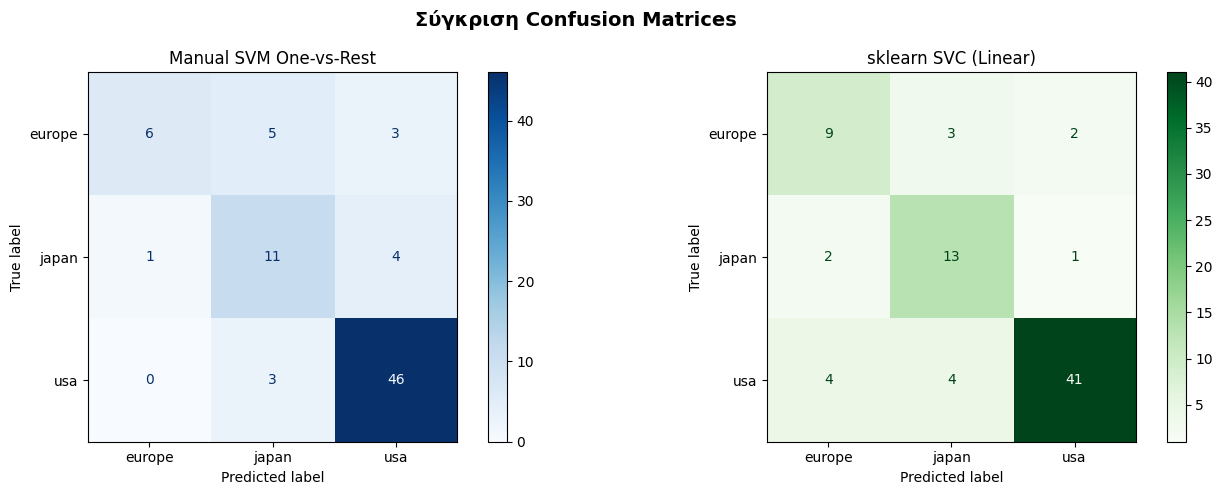

In [84]:
y_pred_sklearn_svm = sklearn_svm.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_manual_svm, display_labels=label_encoder.classes_)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Manual SVM One-vs-Rest')

cm_sklearn_svm = confusion_matrix(y_test, y_pred_sklearn_svm)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn_svm, display_labels=label_encoder.classes_)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('sklearn SVC (Linear)')

plt.suptitle('Σύγκριση Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [80]:
predictions_match_svm = np.sum(y_pred_manual_svm == y_pred_sklearn_svm)
total_predictions_svm = len(y_pred_manual_svm)

print(f"\nPredictions που ταιριάζουν: {predictions_match_svm}/{total_predictions_svm} ({predictions_match_svm/total_predictions_svm*100:.2f}%)")


Predictions που ταιριάζουν: 66/79 (83.54%)


In [81]:
# Λεπτομερής ανάλυση διαφορών
manual_correct = (y_pred_manual_svm == y_test)
sklearn_correct = (y_pred_sklearn_svm == y_test)

both_correct = np.sum(manual_correct & sklearn_correct)
both_wrong = np.sum(~manual_correct & ~sklearn_correct)
manual_only = np.sum(manual_correct & ~sklearn_correct)
sklearn_only = np.sum(~manual_correct & sklearn_correct)

print("=== Λεπτομερής Ανάλυση Προβλέψεων ===")
print(f"\nΚαι οι δύο σωστά:     {both_correct} samples")
print(f"Και οι δύο λάθος:     {both_wrong} samples")
print(f"Μόνο manual σωστά:    {manual_only} samples")
print(f"Μόνο sklearn σωστά:   {sklearn_only} samples")
print(f"\nΣυμφωνία: {both_correct + both_wrong}/{len(y_test)} = {predictions_match_svm}/{total_predictions_svm}")
print(f"\nManual total correct: {both_correct + manual_only} = {np.sum(manual_correct)} (accuracy: {np.sum(manual_correct)/len(y_test):.4f})")
print(f"Sklearn total correct: {both_correct + sklearn_only} = {np.sum(sklearn_correct)} (accuracy: {np.sum(sklearn_correct)/len(y_test):.4f})")

=== Λεπτομερής Ανάλυση Προβλέψεων ===

Και οι δύο σωστά:     57 samples
Και οι δύο λάθος:     10 samples
Μόνο manual σωστά:    6 samples
Μόνο sklearn σωστά:   6 samples

Συμφωνία: 67/79 = 66/79

Manual total correct: 63 = 63 (accuracy: 0.7975)
Sklearn total correct: 63 = 63 (accuracy: 0.7975)


**Σημείωση:** Είναι λογικό να έχουν ίδιο accuracy (79.75%) αλλά διαφορετικές προβλέψεις!

Αυτό σημαίνει ότι οι δύο classifiers κάνουν **διαφορετικά λάθη** σε διαφορετικά samples:
- Από τα 79 test samples, και οι δύο έχουν **63 σωστές προβλέψεις**
- Αλλά δεν είναι οι **ίδιες 63 σωστές προβλέψεις**!
- Κάποια samples ο manual τα βρίσκει σωστά ενώ ο sklearn λάθος (και αντίστροφα)

## 7.7 Συμπεράσματα SVM

- Υλοποιήθηκε Linear SVM με Gradient Descent στο Hinge Loss
- Εφαρμόστηκε η στρατηγική One-vs-Rest για multiclass classification (3 binary classifiers)
- Με σωστά hyperparameters (λ = 1/(2nC), lr = 0.01, iterations = 1000), η manual υλοποίηση επιτυγχάνει **ίδια απόδοση** (σε 2 δεκαδικα ψηφία) με το sklearn SVC (78.59% train, 79.75% test accuracy)
- Η μελέτη του sklearn source code βοήθησε στην κατανόηση της σχέσης μεταξύ των παραμέτρων regularization

---
---
---

# 8. K-Means

**Μέθοδος:** Αλγόριθμος K-Means clustering (θα θεωρήσουμε επομένως άγνωστη την κλάση κάθε παραδείγματος)

---

## 8.1 Manual K-Means Implementation
Κατά την εκπαίδευση **δεν** βλέπει τα y_train. Θα βρει τα clusters με βάση τα χαρακτηριστικά Χ

In [8]:
class KMeansClustering:
    def __init__(self, k=3, max_iters=100, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.cluster_labels = None 

    def fit(self, X):
        #Εκπαίδευση K-Means (χωρίς y)
        
        n_samples, n_features = X.shape
        
        # 1. Τυχαία αρχικοποίηση κέντρων (επιλέγουμε k τυχαία δείγματα)
        np.random.seed(42) # Για επαναληψιμότητα
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        self.centroids = X[random_indices]

        for i in range(self.max_iters):
            # 2. Ανάθεση σε clusters
            # Υπολογίζουμε αποστάσεις από κάθε κέντρο
            # distances: (n_samples, k)
            distances = np.array([np.linalg.norm(X - centroid, axis=1) for centroid in self.centroids]).T
            self.labels = np.argmin(distances, axis=1)

            # 3. Υπολογισμός νέων κέντρων
            new_centroids = np.array([X[self.labels == j].mean(axis=0) for j in range(self.k)])

            # 4. Έλεγχος σύγκλισης
            if np.all(np.linalg.norm(new_centroids - self.centroids, axis=1) < self.tol):
                break
                
            self.centroids = new_centroids

    def predict_clusters(self, X):
        """Επιστρέφει τα Cluster IDs (0, 1, 2...) όχι τα labels"""
        distances = np.array([np.linalg.norm(X - centroid, axis=1) for centroid in self.centroids]).T
        return np.argmin(distances, axis=1)

    def map_clusters_to_labels(self, X_train, y_train):
        """
        Αντιστοιχίζει κάθε Cluster ID στο πραγματικό Label που πλειοψηφεί μέσα σε αυτό.
        Απαραίτητο για να μετρήσουμε Accuracy.
        """
        # Παίρνουμε τα cluster assignments για το train set
        train_clusters = self.predict_clusters(X_train)
        
        self.cluster_map = {}
        for cluster_id in range(self.k):
            # Βρίσκουμε τα πραγματικά labels των σημείων που ανήκουν σε αυτό το cluster
            labels_in_cluster = y_train[train_clusters == cluster_id]
            
            if len(labels_in_cluster) > 0:
                # Βρίσκουμε το πιο συχνό label (mode)
                most_common = Counter(labels_in_cluster).most_common(1)[0][0]
                self.cluster_map[cluster_id] = most_common
            else:
                self.cluster_map[cluster_id] = np.random.choice(y_train) # Fallback

    def predict(self, X):
        """Πρόβλεψη τελικών Labels (μετά το mapping)"""
        clusters = self.predict_clusters(X)
        return np.array([self.cluster_map[c] for c in clusters])

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

## 8.2 Εκπαίδευση - Mapping - Αξιολόγηση

In [9]:
# 1. Instantiation (K=3 όσες και οι κλάσεις)
kmeans = KMeansClustering(k=3)

# 2. Εκπαίδευση (ΜΟΝΟ με X_train, αγνοούμε τα y_train αρχικά)
kmeans.fit(X_train_scaled)

# 3. Mapping: Τώρα χρησιμοποιούμε τα y_train για να δώσουμε "όνομα" στα clusters
kmeans.map_clusters_to_labels(X_train_scaled, y_train)

# 4. Αξιολόγηση
train_acc_km = kmeans.score(X_train_scaled, y_train)
test_acc_km = kmeans.score(X_test_scaled, y_test)

print("=== Αποτελέσματα K-Means Clustering ===")
print(f"Accuracy on Train Set: {train_acc_km:.4f} ({train_acc_km*100:.2f}%)")
print(f"Accuracy on Test Set:  {test_acc_km:.4f} ({test_acc_km*100:.2f}%)")

=== Αποτελέσματα K-Means Clustering ===
Accuracy on Train Set: 0.6422 (64.22%)
Accuracy on Test Set:  0.6456 (64.56%)


## 8.3 Confusion matrix - Manual K-Means

<Figure size 800x600 with 0 Axes>

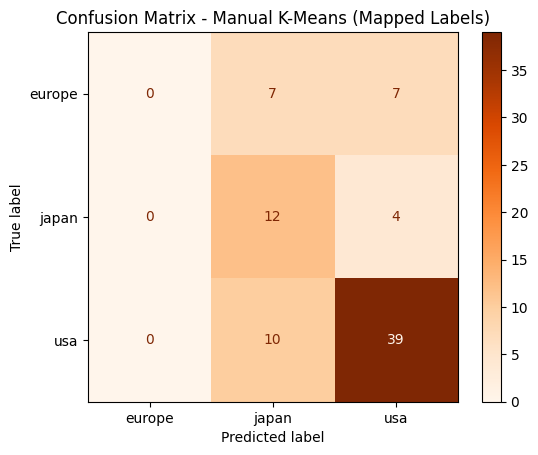


Classification Report (Manual K-Means):
              precision    recall  f1-score   support

      europe       0.00      0.00      0.00        14
       japan       0.41      0.75      0.53        16
         usa       0.78      0.80      0.79        49

    accuracy                           0.65        79
   macro avg       0.40      0.52      0.44        79
weighted avg       0.57      0.65      0.60        79



/Users/giman/Desktop/auto-mpg-classification-analysis/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/giman/Desktop/auto-mpg-classification-analysis/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/giman/Desktop/auto-mpg-classification-analysis/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

In [24]:
y_pred_manual_km = kmeans.predict(X_test_scaled)

cm_manual_km = confusion_matrix(y_test, y_pred_manual_km)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_manual_km, display_labels=label_encoder.classes_)
disp.plot(cmap='Oranges', values_format='d')
plt.title('Confusion Matrix - Manual K-Means (Mapped Labels)')
plt.show()

print("\nClassification Report (Manual K-Means):")
print(classification_report(y_test, y_pred_manual_km, target_names=label_encoder.classes_))

## 8.4 Verification με Sklearn KMeans

In [11]:
print("\n### Verification with sklearn (KMeans) ###")

# Sklearn Implementation
sklearn_kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
sklearn_kmeans.fit(X_train_scaled)

# --- Helper για Mapping του Sklearn ---
def map_sklearn_clusters(kmeans_model, X, y):
    clusters = kmeans_model.predict(X)
    labels = np.zeros_like(clusters)
    for i in range(3):
        mask = (clusters == i)
        if np.any(mask):
            # Βρες το πιο συχνό label σε αυτό το cluster
            # (Χρησιμοποιούμε mode από scipy.stats)
            labels[mask] = mode(y[mask], keepdims=True)[0][0]
    return labels

# Υπολογισμός προβλέψεων (mapped)
y_train_pred_sklearn = map_sklearn_clusters(sklearn_kmeans, X_train_scaled, y_train)
y_test_pred_sklearn = map_sklearn_clusters(sklearn_kmeans, X_test_scaled, y_test)

# Υπολογισμός Accuracy (Χωρίς accuracy_score, απευθείας με numpy όπως στην κλάση μας)
sk_train_acc_km = np.mean(y_train == y_train_pred_sklearn)
sk_test_acc_km = np.mean(y_test == y_test_pred_sklearn)


# Πίνακας Σύγκρισης
print("\n" + "="*60)
print(f"{'ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ (K-Means)':^60}")
print("="*60)
print(f"\n{'Metric':<20} {'Manual':>12} {'sklearn':>12} {'Διαφορά':>12}")
print("-" * 60)
print(f"{'Train Accuracy':<20} {train_acc_km:>12.4f} {sk_train_acc_km:>12.4f} {abs(train_acc_km - sk_train_acc_km):>12.6f}")
print(f"{'Test Accuracy':<20} {test_acc_km:>12.4f} {sk_test_acc_km:>12.4f} {abs(test_acc_km - sk_test_acc_km):>12.6f}")
print("-" * 60)


### Verification with sklearn (KMeans) ###

              ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ (K-Means)              

Metric                     Manual      sklearn      Διαφορά
------------------------------------------------------------
Train Accuracy             0.6422       0.6422     0.000000
Test Accuracy              0.6456       0.6203     0.025316
------------------------------------------------------------


Παρατηρούμε ταύτιση στο train set και πολύ μικρή διαφορά στο test set, το οποίο είναι ικανοποιητικό

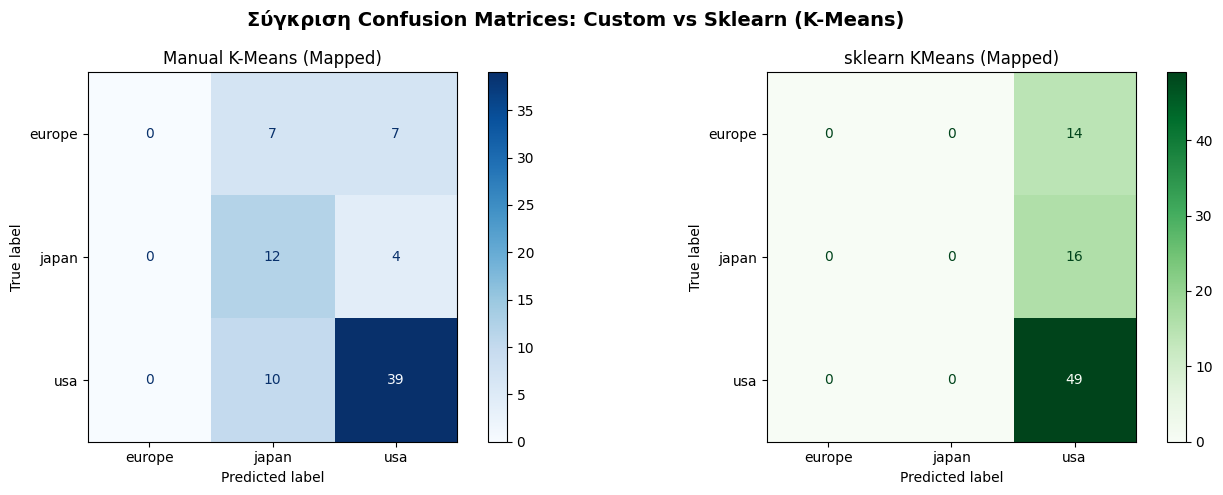

In [12]:
y_pred_manual_km = kmeans.predict(X_test_scaled)

y_pred_sklearn_km = map_sklearn_clusters(sklearn_kmeans, X_test_scaled, y_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_manual_km = confusion_matrix(y_test, y_pred_manual_km)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_manual_km, display_labels=label_encoder.classes_)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Manual K-Means (Mapped)')

cm_sklearn_km = confusion_matrix(y_test, y_pred_sklearn_km)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn_km, display_labels=label_encoder.classes_)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('sklearn KMeans (Mapped)')

plt.suptitle('Σύγκριση Confusion Matrices: Custom vs Sklearn (K-Means)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8.5 Συμπεράσματα K-Means


* Για την αξιολόγηση, έγινε αντιστοίχιση (mapping) κάθε cluster στην πλειοψηφούσα κλάση του. Χωρίς αυτό, δεν θα μπορούσαμε να υπολογίσουμε Accuracy.

* Η ταύτιση της ακρίβειας στο Train set (64.22%) μεταξύ της Manual υλοποίησης και της βιβλιοθήκης scikit-learn επιβεβαιώνει ότι ο αλγόριθμος συσταδοποίησης λειτουργεί σωστά και εντόπισε τα ίδια κεντροειδή.
* Η μικρή απόκλιση στο Test set (~2.5%) είναι αναμενόμενη λόγω διαφορών στην αριθμητική ακρίβεια (floating point precision) κατά τον υπολογισμό των αποστάσεων για οριακά σημεία.


* Το Accuracy κυμαίνεται στο **64%**. Το ποσοστό αυτό είναι σημαντικά χαμηλότερο από τις μεθόδους επιβλεπόμενης μάθησης (Supervised Learning) που είδαμε προηγουμένως (π.χ. KNN ~80%).
    * Αυτό συμβαίνει διότι ο K-Means αγνοεί τις ετικέτες και ομαδοποιεί τα δεδομένα αποκλειστικά με βάση τη γεωμετρική εγγύτητα (Ευκλείδεια απόσταση).



* Το Confusion Matrix δείχνει ότι ο αλγόριθμος δυσκολεύεται να διαχωρίσει πλήρως κάποιες κλάσεις (πιθανότατα Ευρώπη και Ιαπωνία που έχουν παρόμοια χαρακτηριστικά οικονομίας καυσίμου), ενώ ίσως ξεχωρίζει καλύτερα τα Αμερικάνικα αυτοκίνητα που τείνουν να είναι μεγαλύτερα και ισχυρότερα.